# MGMTMSA438-1 Sports Analytics - Final Project
### Student Name: Bryan Kar Syn HO

1.	What is your project topic?  Briefly summarize what you’re trying to accomplish
- Use player statistics to determine / redefine "position types" of players
2.	What were the “results” of your work?  (What does your software package “do”, or what were the relevant evaluation metrics for your model, or what were the relationships between variables you were exploring, etc.)
3.	What would the next logical step be in this exploration?
- Better ways to formulate a well rounded team out of this analysis?
- potential player evolution based on past players?
4.	What did you find difficult to do during the project?
5.	What topic did you wish you were more knowledgeable about/what would have been handy to know while you were doing the project?

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import fcluster

In [2]:
#Import dataset for 2018-2019 season players' per 36 min stats. Only including those that have played at least 6x 36 minutes = 216 minutes in the season
data = pd.read_csv("1819_player_36min_data.csv")

In [3]:
#Replace null values under 3P% to 0 for some players with no 3P attempts
data['3P%'] = data['3P%'].fillna(0)

In [4]:
#Adding a new field as GS%, standing for percentage of games started, as this could potentially indicate the player's role on the team as well
data['GS%'] = data['GS']/data['G']

In [5]:
#Drop categorical fields and player names, also dropping irrelevant fields of Games started and Minutes played
X = data.drop(['Player','Pos','Tm','GS','MP'], axis=1).to_numpy()

In [6]:
X.shape

(417, 24)

Create clusters using Hierarchical Clustering and Dendrogram:

In [7]:
Z = linkage(X, 'ward')

In [8]:
c, coph_dists = cophenet(Z, pdist(X))

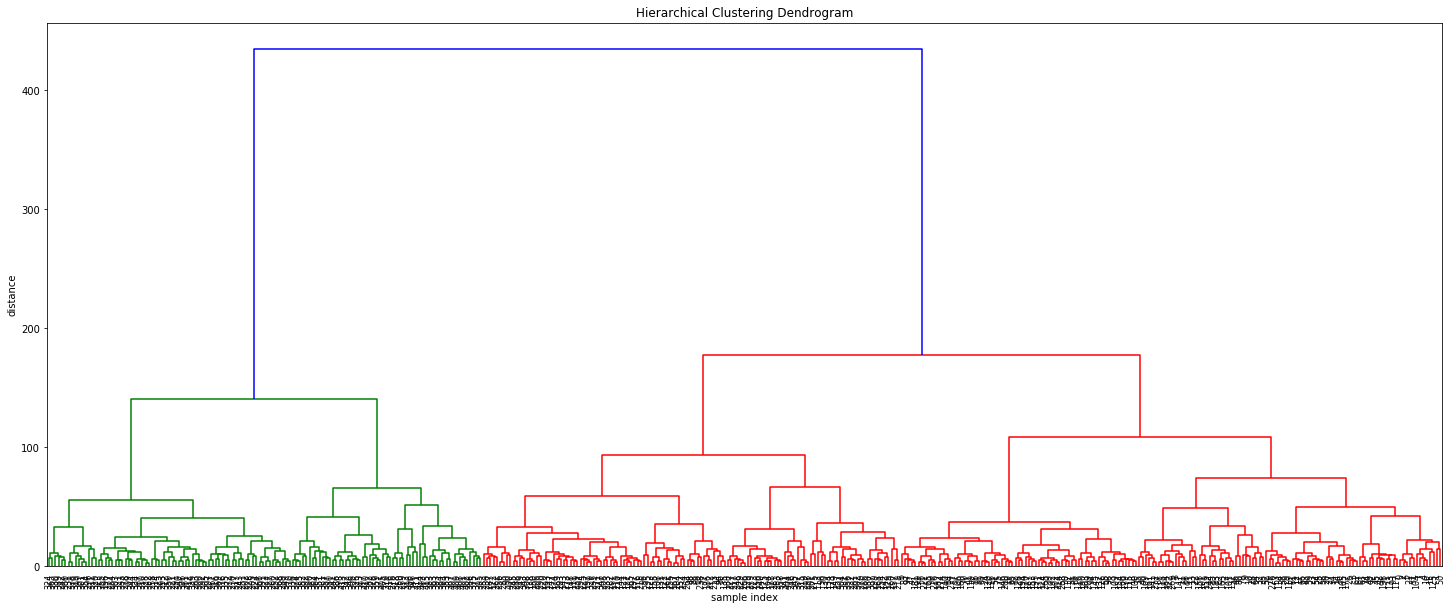

In [9]:
# calculate full dendrogram
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.show()

In the above fully plotted dendrogram, we can see that the distance between clusters start to diminish after around 10 clusters. So we will use 10 clusters as the cut off, with the updated plot below:

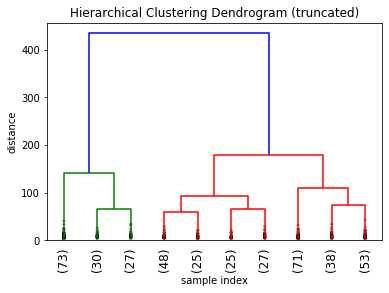

In [10]:
plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=10,  # show only the last p merged clusters
#    show_leaf_counts=False,  # otherwise numbers in brackets are counts
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True  # to get a distribution impression in truncated branches
)
plt.show()

In [11]:
#k here is the number of clusters
k=10
clusters = fcluster(Z, k, criterion='maxclust')

We can now merge the determined clusters to the player data and determine what each of these clusters categorize:

In [12]:
data['cluster'] = clusters

In [13]:
pd.DataFrame(data[data['cluster']==1].mean()).T

,Age,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,...,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,GS%,cluster
0,25.013699,45.30137,14.506849,789.671233,4.960274,11.242466,0.446205,1.349315,4.086301,0.275,...,5.238356,7.019178,3.445205,1.034247,0.783562,1.9,3.726027,13.191781,0.321838,1.0


In [14]:
cluster_mean_data = pd.DataFrame(data[data['cluster']==1].mean()).T

In [15]:
for i in range(2,11):
    cluster_mean_data = cluster_mean_data.append(pd.DataFrame(data[data['cluster']==i].mean()).T)

In [16]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [17]:
cluster_mean_data = cluster_mean_data.reset_index(drop=True)

In [18]:
cols = list(cluster_mean_data)
cols.insert(0, cols.pop(cols.index('cluster')))
cols.insert(4, cols.pop(cols.index('GS%')))

In [19]:
cluster_mean_data = cluster_mean_data.loc[:, cols]

In [20]:
cm = sns.light_palette("green", as_cmap=True)

s = cluster_mean_data.style.background_gradient(cmap=cm)
s

,cluster,Age,G,GS,GS%,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,1,25.0137,45.3014,14.5068,0.321838,789.671,4.96027,11.2425,0.446205,1.34932,4.0863,0.275,3.61507,7.15342,0.504562,1.92466,2.69178,0.713082,1.77808,5.23836,7.01918,3.44521,1.03425,0.783562,1.9,3.72603,13.1918
1,2,27.6,32.0333,6.33333,0.201754,469.8,4.14,9.58333,0.436933,1.30333,4.11,0.2769,2.81333,5.47333,0.5016,1.45667,2.03333,0.737233,1.48333,4.89333,6.38333,2.50667,1.16,0.92,1.45,3.91667,11.02
2,3,27.2963,23.4444,6.92593,0.2814,460.333,6.13704,13.8741,0.444333,1.58148,4.65185,0.311667,4.57037,9.22963,0.487148,2.81481,3.91481,0.727444,1.44074,5.21111,6.65185,3.5963,1.16296,0.692593,2.06667,3.71481,16.6889
3,4,25.3333,63.9375,19.6667,0.306313,1272.44,4.50625,10.0667,0.449562,1.4375,4.15,0.319917,3.05833,5.92708,0.515396,1.64583,2.2625,0.734208,1.43333,4.82708,6.24792,2.98542,1.08958,0.772917,1.57083,3.37083,12.1042
4,5,32.36,69.36,34.6,0.501295,1696.84,5.568,12.572,0.44676,2.076,5.788,0.33016,3.496,6.792,0.50792,2.54,3.196,0.79772,1.436,5.244,6.688,3.388,1.1,0.644,1.992,3.34,15.764
5,6,29.12,55.28,18.32,0.330791,1129.68,5.252,12.432,0.42432,2.064,5.852,0.34932,3.172,6.572,0.48816,1.892,2.408,0.78492,0.768,4.064,4.836,3.432,1.244,0.4,1.776,3.12,14.452
6,7,23.9259,56.8519,26.1481,0.46578,1283.33,7.8037,15.9222,0.492148,1.08519,3.22222,0.288704,6.72593,12.6963,0.527,3.55185,4.7963,0.736815,2.25185,6.30741,8.54815,3.3963,0.948148,0.918519,2.4037,3.25926,20.237
7,8,26.0563,77.1831,38.0845,0.490887,1889.77,4.91972,11.1099,0.443042,1.92394,5.21549,0.36131,3.00141,5.89718,0.510028,1.70141,2.15775,0.785338,1.03803,4.26056,5.29437,3.17183,1.11972,0.547887,1.48873,2.95634,13.4676
8,9,25.6053,76.2105,52.2368,0.687132,2017.5,7.42895,13.3526,0.564158,0.418421,1.32895,0.204026,7.01053,12.0211,0.588079,3.41316,4.84211,0.697842,3.53947,8.07105,11.6105,3.14474,1.12105,1.59474,2.26316,3.76316,18.6789
9,10,25.6415,75.0566,59.717,0.795361,2333.42,7.84906,17.5415,0.448434,2.36792,6.55283,0.360509,5.4717,10.983,0.499132,3.88491,4.77925,0.809698,1.01698,4.56415,5.57736,4.75472,1.1717,0.484906,2.6,2.59245,21.9566


Base off of how each cluster's summary statistics compare against the other, we can make some assumptions on their player type.

- Cluster 1 - Role Player. Not afraid to take shots, make plays and hustle on both ends. Aggressive defenders. e.g.

In [21]:
data[data['cluster']==1][['Player','Pos']].head(5)

,Player,Pos
196,Lonzo Ball,PG
202,Kris Dunn,PG
205,Rajon Rondo,PG
207,T.J. Warren,SF
221,Kyle Anderson,SF


- Cluster 2 - Defenders. Grabbing boards, making steals and taking fouls. e.g.

In [22]:
data[data['cluster']==2][['Player','Pos']].head(5)

,Player,Pos
241,Robert Covington,SF
306,Bruno Caboclo,PF
326,Treveon Graham,SG
336,Jerryd Bayless,PG
342,Isaiah Canaan,PG


- Cluster 3 - Playmaking Scorers. Take many shots and go to the line often. e.g.:

In [23]:
data[data['cluster']==3][['Player','Pos']].head(5)

,Player,Pos
250,Victor Oladipo,SG
259,John Wall,PG
276,Goran Dragić,PG
313,DeMarcus Cousins,C
318,J.J. Barea,PG


- Cluster 4 - Offense Facilitators. Usually a starter, well-rounded player delivery solid numbers across all fronts. e.g.:

In [24]:
data[data['cluster']==4][['Player','Pos']].head(5)

,Player,Pos
90,Draymond Green,PF
111,Justise Winslow,SF
121,Avery Bradley,SG
127,Reggie Bullock,SG
138,Larry Nance Jr.,C


- Cluster 5 - Elite Veterans. Older players but still playing long minutes and scoring often from beyond the arc. e.g.:

In [25]:
data[data['cluster']==5][['Player','Pos']].head(5)

,Player,Pos
44,J.J. Redick,SG
48,Trevor Ariza,SF
69,Kyle Lowry,PG
77,Eric Gordon,SG
86,Jeff Green,PF


- Cluster 6 - 3&D. Tend to take high percentage 3 point shots and also excel at defense. e.g.:

In [26]:
data[data['cluster']==6][['Player','Pos']].head(5)

,Player,Pos
129,Chris Paul,PG
156,Otto Porter,SF
164,Gary Harris,SG
175,Taurean Prince,SF
178,Tyler Johnson,PG


- Cluster 7 - Elite All-Round Players. Take many high percentage shots, go to the line often and also excel on the defensive end. e.g.:

In [27]:
data[data['cluster']==7][['Player','Pos']].head(5)

,Player,Pos
96,Kawhi Leonard,SF
113,LeBron James,SF
130,Anthony Davis,C
134,John Collins,PF
142,Brandon Ingram,SF


- Cluster 8 - Elite Scorers. High percentage shooters. e.g.:

In [28]:
data[data['cluster']==8][['Player','Pos']].head(5)

,Player,Pos
6,P.J. Tucker,PF
18,Jerami Grant,PF
19,Justin Holiday,SG
24,Joe Ingles,PF
30,Josh Richardson,SG


- Cluster 9 - Pure Playmakers. Seldom take 3s, only takes high percentage inside shots and able to facilitate the game on all other fronts. Eats double-doubles (points & rebounds) for breakfast. e.g.:

In [29]:
data[data['cluster']==9][['Player','Pos']].head(5)

,Player,Pos
8,Ben Simmons,PG
9,DeMar DeRozan,SG
10,LaMarcus Aldridge,C
11,Steven Adams,C
13,Andre Drummond,C


- Cluster 10 - Elite Swingmen. Usually smaller players, ball handlers who can score at ease at any range, score a lot themselves and also create many scoring opportunities for teammates. Usually a core player on their team playing long minutes. e.g.:

In [30]:
data[data['cluster']==10][['Player','Pos']].head(5)

,Player,Pos
0,Bradley Beal,SG
1,James Harden,PG
2,Kemba Walker,PG
3,Tobias Harris,PF
4,Paul George,SF
